In [9]:
!pip install ffmpeg-python

import ffmpeg # ffmpeg-python library for using ffprobe/ffmpeg
from pprint import pprint
import subprocess, json

# Step 1: Define the path to the video file for which we want metadata.
video_path = "/kaggle/input/metadata-dataset/Meta_Data_Dataset/fake_videos/VID-20251204-WA0057.mp4"# TODO: replace with the actual video file path

# Step 2: Use ffprobe to get metadata in JSON format.
# The ffprobe command:
# - -v quiet    : reduces output to only the data we need
# - -print_format json : outputs the data in JSON format for easy parsing
# - -show_format : shows container-level metadata (overall file info)
# - -show_streams: shows stream-level metadata (video stream, audio stream info, etc.)
try:
    result = subprocess.run(
        ["ffprobe", "-v", "quiet", "-print_format", "json", "-show_format", "-show_streams", video_path],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True
    )
except subprocess.CalledProcessError as e:
    print("FFprobe error, could not retrieve metadata. Check that the video path is correct and ffprobe is installed.")
    print(e.stderr.decode())
else:
    # Parse the JSON output
    metadata = json.loads(result.stdout)
    
    # For demonstration, let's extract some key features from the metadata:
    features = {}  # dictionary to hold our extracted metadata features
    
    # 1. Video codec name
    # ffprobe lists streams; we need to find the video stream (usually where "codec_type":"video").
    video_stream = None
    for stream in metadata.get("streams", []):
        if stream.get("codec_type") == "video":
            video_stream = stream
            break
    if video_stream:
        features["v_codec"] = video_stream.get("codec_name", "unknown")
        features["v_width"] = video_stream.get("width", 0)
        features["v_height"] = video_stream.get("height", 0)
        # frame rate might be given as a string like "30/1", we can compute it:
        if "avg_frame_rate" in video_stream:
            fps_str = video_stream["avg_frame_rate"]
            if fps_str != "0/0":
                # Calculate frame rate as float
                num, denom = fps_str.split('/')
                if denom != "0":
                    features["v_fps"] = float(num) / float(denom)
                else:
                    features["v_fps"] = 0.0
        # Bit rate of the video stream (in bits per second)
        if "bit_rate" in video_stream:
            features["v_bitrate"] = int(video_stream["bit_rate"])
    
    # 2. Audio codec name and bitrate (if audio stream exists)
    audio_stream = None
    for stream in metadata.get("streams", []):
        if stream.get("codec_type") == "audio":
            audio_stream = stream
            break
    if audio_stream:
        features["a_codec"] = audio_stream.get("codec_name", "unknown")
        # Audio bitrate
        if "bit_rate" in audio_stream:
            features["a_bitrate"] = int(audio_stream["bit_rate"])
    
    # 3. Container format info (from "format" section)
    format_info = metadata.get("format", {})
    # total bitrate of file (could be overall bitrate including audio+video)
    if "bit_rate" in format_info:
        features["overall_bitrate"] = int(format_info["bit_rate"])
    if "duration" in format_info:
        features["duration"] = float(format_info["duration"])
    if "format_name" in format_info:
        features["container"] = format_info["format_name"]  # e.g., "mov,mp4,m4a,3gp,3g2,mj2"
    
    # 4. (Optional) Encoder software, if available (sometimes in format tags)
    if "tags" in format_info:
        # Common tag for encoder
        encoder = format_info["tags"].get("encoder") or format_info["tags"].get("ENCODER")
        if encoder:
            features["encoder"] = encoder
    
    # Now we have extracted some metadata features into the dictionary.
    print("Extracted metadata features:")
    for key, value in features.items():
        print(f"  {key}: {value}")
    
    # Step 4: Use criteria or model to decide fake vs real.
    # (Here we just illustrate how you might make a decision or use a model.)
    
    # Example of simple heuristic (this is just for illustration; you'd use a trained model for real criteria):
    is_fake = False  # default assumption
    # Suppose from training we observed that deepfake videos tend to have lower video bitrate:
    if features.get("v_bitrate", 0) and features["v_bitrate"] < 500000:
        # If video bitrate is below 500 kbps, we suspect it might be fake (for example)
        is_fake = True
    
    # We could add more heuristic checks, e.g., specific encoder tag or odd fps:
    if features.get("encoder") and "Lavf" in features["encoder"]:
        # If encoder tag contains "Lavf" (Lavf is FFmpeg libavformat), it means the video was processed by FFmpeg.
        # Many deepfakes might be encoded with FFmpeg, so this could be a hint.
        is_fake = True
    
    # Print the heuristic decision
    if is_fake:
        print("Heuristic Metadata Verdict: This video is LIKELY FAKE based on metadata patterns.")
    else:
        print("Heuristic Metadata Verdict: Metadata looks normal; the video is likely REAL (or no clear fake indicators).")
    
    # In practice, instead of simple rules, you would feed 'features' into a trained classifier:
    # e.g., model.predict(vectorize(features)) -> probability of fake.
    # Here we assume that part (training the classifier on metadata) is done separately.

Extracted metadata features:
  v_codec: h264
  v_width: 1280
  v_height: 720
  v_fps: 24.0
  v_bitrate: 3400133
  a_codec: aac
  a_bitrate: 139981
  overall_bitrate: 3528724
  duration: 8.042667
  container: mov,mp4,m4a,3gp,3g2,mj2
Heuristic Metadata Verdict: Metadata looks normal; the video is likely REAL (or no clear fake indicators).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install ffmpeg-python


Note: you may need to restart the kernel to use updated packages.


In [4]:
# 1) IMPORTS
# ==========================================
import os
import json
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import ffmpeg


In [14]:
import os
import pandas as pd
import ffmpeg
from tqdm import tqdm

# Paths to your real and fake video folders
REAL_DIR = '/kaggle/input/original-metadata/Meta_Data_Dataset/Real_videos'
FAKE_DIR = '/kaggle/input/original-metadata/Meta_Data_Dataset/fake_videos'

# Function to extract metadata features from a video file
def extract_metadata(video_path):
    try:
        probe = ffmpeg.probe(video_path)
        format_info = probe.get('format', {})
        streams = probe.get('streams', [])

        # Extracting general format-level metadata
        metadata = {
            'filename': os.path.basename(video_path),
            'duration': float(format_info.get('duration', 0)),
            'overall_bitrate': int(format_info.get('bit_rate', 0)),
            'container': format_info.get('format_name', '')
        }

        for stream in streams:
            if stream['codec_type'] == 'video':
                metadata.update({
                    'v_codec': stream.get('codec_name', ''),
                    'v_width': int(stream.get('width', 0)),
                    'v_height': int(stream.get('height', 0)),
                    'v_fps': eval(stream.get('r_frame_rate', '0')),  # e.g. "30/1"
                    'v_bitrate': int(stream.get('bit_rate', 0))
                })

            elif stream['codec_type'] == 'audio':
                metadata.update({
                    'a_codec': stream.get('codec_name', ''),
                    'a_bitrate': int(stream.get('bit_rate', 0))
                })

        return metadata
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return None

# Loop over both real and fake folders and build metadata DataFrame
def build_metadata_csv(real_dir, fake_dir, output_csv='video_metadata.csv'):
    all_data = []
    
    for label, folder in [(0, real_dir), (1, fake_dir)]:
        for filename in tqdm(os.listdir(folder), desc=f"Processing {'real' if label==0 else 'fake'} videos"):
            if filename.endswith('.mp4'):
                video_path = os.path.join(folder, filename)
                metadata = extract_metadata(video_path)
                if metadata:
                    metadata['label'] = label
                    all_data.append(metadata)

    df = pd.DataFrame(all_data)
    df.to_csv(output_csv, index=False)
    print(f"Saved metadata CSV to {output_csv}")

# Run the metadata extraction
build_metadata_csv(REAL_DIR, FAKE_DIR)  # <- You can modify this path if needed


Processing fake videos: 100%|██████████| 77/77 [00:08<00:00,  9.04it/s]

Saved metadata CSV to video_metadata.csv


In [11]:
# -------------------------------------------
# CHUNK 2 — Check if real and fake folders exist
# -------------------------------------------

print("Checking dataset folders...")
print("Real videos folder exists:", os.path.isdir(REAL_DIR))
print("Fake videos folder exists:", os.path.isdir(FAKE_DIR))


Checking dataset folders...
Real videos folder exists: True
Fake videos folder exists: True


In [5]:
import pandas as pd
df2=pd.read_csv("/kaggle/working/video_metadata.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/video_metadata.csv'

In [17]:
df2.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,filename,duration,overall_bitrate,container,v_codec,v_width,v_height,v_fps,v_bitrate,a_codec,a_bitrate,label
0,D21_V_indoor_move_0001.mp4,86.571000,20118565,"mov,mp4,m4a,3gp,3g2,mj2",h264,1920,1080,29.250000,20004961,aac,96035.0,0
1,D21_V_flatWA_still_0001.mp4,71.336327,526514,"mov,mp4,m4a,3gp,3g2,mj2",h264,848,480,29.250000,464997,aac,56628.0,0
2,WhatsApp Video 2025-12-04 at 15.55.23_852fc4f1...,13.529333,980151,"mov,mp4,m4a,3gp,3g2,mj2",h264,476,848,29.833333,977838,NaN,NaN,0
3,D26_V_indoorWA_move_0001.mp4,72.230000,1304584,"mov,mp4,m4a,3gp,3g2,mj2",h264,848,480,600.000000,1247839,aac,52707.0,0
4,WhatsApp Video 2025-12-04 at 16.00.48_c349259e...,19.893333,1137376,"mov,mp4,m4a,3gp,3g2,mj2",h264,478,850,30.000000,1003179,aac,131214.0,0


In [2]:
#import all libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
df2=pd.read_csv("/kaggle/input/meta-data-dataset/video_metadata (3).csv")  

print("Shape:", df2.shape)
df2.head()

Shape: (150, 12)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,filename,duration,overall_bitrate,container,v_codec,v_width,v_height,v_fps,v_bitrate,a_codec,a_bitrate,label
0,D21_V_indoor_move_0001.mp4,86.571000,20118565,"mov,mp4,m4a,3gp,3g2,mj2",h264,1920,1080,29.250000,20004961,aac,96035.0,0
1,D21_V_flatWA_still_0001.mp4,71.336327,526514,"mov,mp4,m4a,3gp,3g2,mj2",h264,848,480,29.250000,464997,aac,56628.0,0
2,WhatsApp Video 2025-12-04 at 15.55.23_852fc4f1...,13.529333,980151,"mov,mp4,m4a,3gp,3g2,mj2",h264,476,848,29.833333,977838,NaN,NaN,0
3,D26_V_indoorWA_move_0001.mp4,72.230000,1304584,"mov,mp4,m4a,3gp,3g2,mj2",h264,848,480,600.000000,1247839,aac,52707.0,0
4,WhatsApp Video 2025-12-04 at 16.00.48_c349259e...,19.893333,1137376,"mov,mp4,m4a,3gp,3g2,mj2",h264,478,850,30.000000,1003179,aac,131214.0,0


In [17]:
RANDOM_STATE = 42
# Ensure required columns exist
required_cols = ["filename", "duration", "overall_bitrate", "container", "v_codec",
                 "v_width", "v_height", "v_fps", "v_bitrate", "a_codec", "a_bitrate", "label"]
missing = [c for c in required_cols if c not in df2.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# -------------------------
# 3) Feature engineering (derived features)
# -------------------------
eps = 1e-6
df2["bitrate_per_pixel"] = df2["v_bitrate"] / (df2["v_width"] * df2["v_height"] + eps)
df2["quality_factor"] = df2["v_bitrate"] / (df2["v_fps"] + eps)
df2["av_bitrate_ratio"] = df2["a_bitrate"] / (df2["v_bitrate"] + eps)
df2["bitrate_duration_ratio"] = df2["overall_bitrate"] / (df2["duration"] + eps)
df2["pixel_count"] = df2["v_width"] * df2["v_height"]

numeric_features = ["duration", "overall_bitrate", "v_width", "v_height", "v_fps",
                    "v_bitrate", "a_bitrate", "bitrate_per_pixel", "quality_factor",
                    "av_bitrate_ratio", "bitrate_duration_ratio", "pixel_count"]

categorical_features = ["container", "v_codec", "a_codec"]

X = df2[numeric_features + categorical_features]
y = df2["label"].astype(int)

# -------------------------
# 4) Split data
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# 5) Preprocessing pipeline
# -------------------------
# Numeric → median imputer + standard scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical → most frequent imputer + one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# -------------------------
# 6) Random Forest classifier
# -------------------------
clf = RandomForestClassifier(
    n_estimators=200,     # reduced to prevent overfitting
    max_depth=7,          # smaller depth
    min_samples_leaf=2,   # prevent too specific leaves
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Create pipeline: preprocessing + classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# -------------------------
# 7) Train model
# -------------------------
model_pipeline.fit(X_train, y_train)

# -------------------------
# 8) Evaluate model
# -------------------------
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))




Test Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.93      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [18]:
# -------------------------
# 1) Training predictions
# -------------------------
y_train_pred = model_pipeline.predict(X_train)
y_train_proba = model_pipeline.predict_proba(X_train)[:, 1]

train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# -------------------------
# 2) Testing predictions
# -------------------------
y_test_pred = model_pipeline.predict(X_test)
y_test_proba = model_pipeline.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_acc:.4f}")
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

# -------------------------
# 3) Compare accuracies
# -------------------------
print("\nDifference between training and testing accuracy:", train_acc - test_acc)

if train_acc - test_acc > 0.05:
    print("Warning: Possible overfitting detected (train >> test).")
else:
    print("Model generalization seems reasonable.")


Training Accuracy: 0.9917
Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.98      0.99        62

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Testing Accuracy: 0.9667
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.93      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Difference between training and testing accuracy: 0.025000000000000022
Model generalization seems reasonable.


Training Accuracy: 0.9917
Testing Accuracy: 0.9667


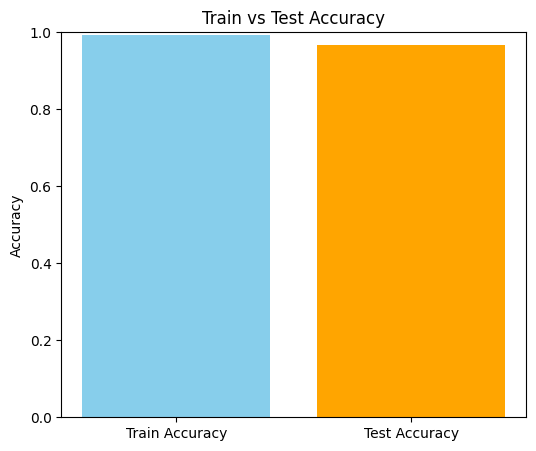

5-Fold CV Accuracies: [1.         0.93333333 0.86666667 0.93333333 0.96666667]
Mean CV Accuracy: 0.9400
Std of CV Accuracy: 0.0442


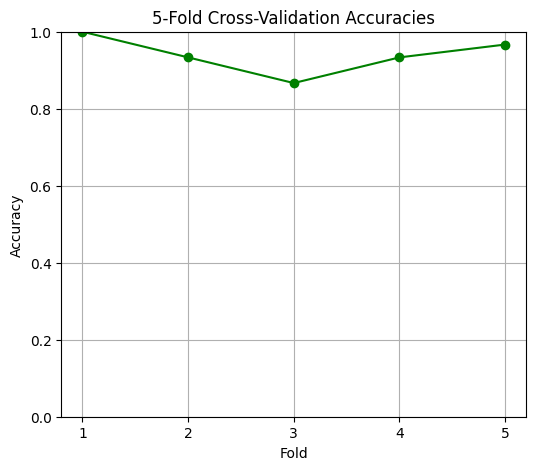

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

# -------------------------
# 1) Training and Testing Accuracy
# -------------------------
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

# Plot training vs test accuracy
plt.figure(figsize=(6,5))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'orange'])
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.show()

# -------------------------
# 2) k-Fold Cross-Validation
# -------------------------
k = 5  # you can change k
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_scores = cross_val_score(model_pipeline, X, y, cv=cv, scoring='accuracy')

print(f"{k}-Fold CV Accuracies: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Std of CV Accuracy: {cv_scores.std():.4f}")

# Optional: plot CV accuracies
plt.figure(figsize=(6,5))
plt.plot(range(1, k+1), cv_scores, marker='o', linestyle='-', color='green')
plt.xticks(range(1, k+1))
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'{k}-Fold Cross-Validation Accuracies')
plt.ylim(0,1)
plt.grid(True)
plt.show()


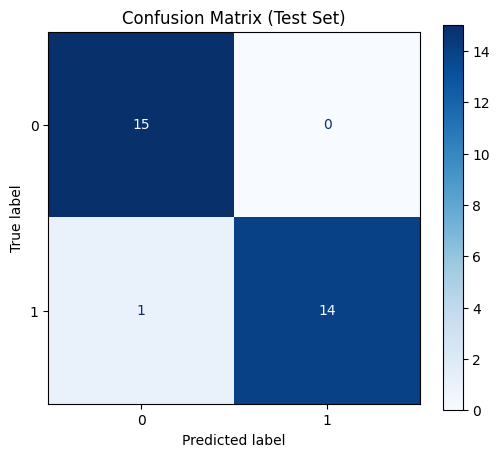

In [20]:
#confusion metrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_test_pred = model_pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Optional: save the figure
fig.savefig("confusion_matrix_test.png", bbox_inches='tight')


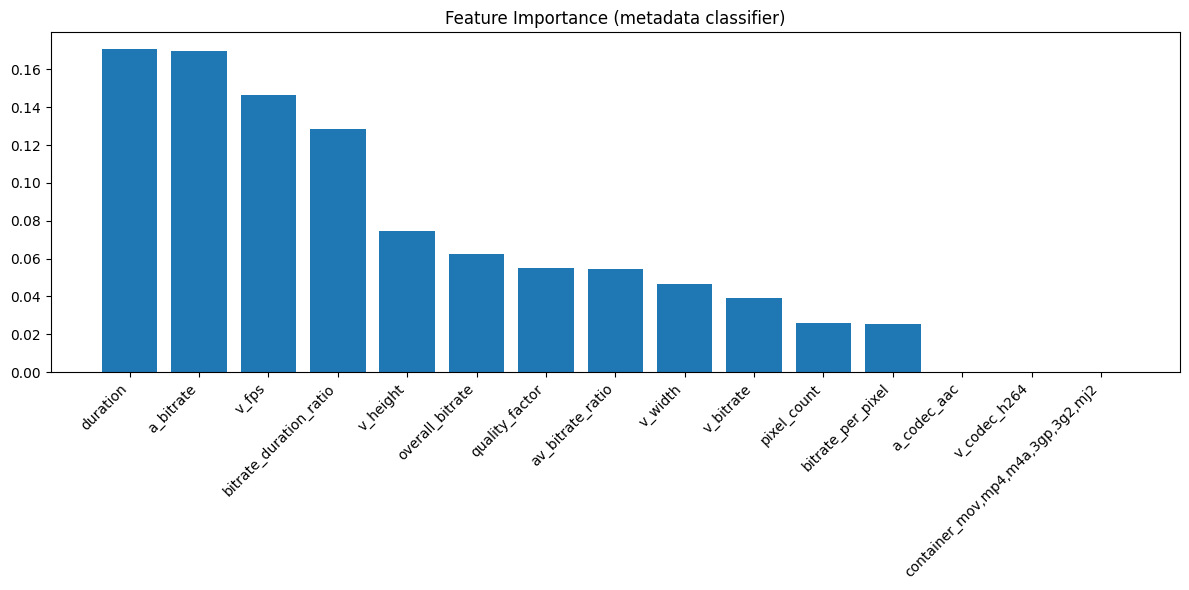

In [21]:
 #Extract feature importances from Random Forest
# One-hot categorical features → combine names
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_feature_names)

importances = model_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(len(importances)), importances[indices])
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([all_features[i] for i in indices], rotation=45, ha='right')
ax.set_title("Feature Importance (metadata classifier)")
plt.tight_layout()
plt.show()

In [16]:
 #12) Save pipeline and artifacts
# -------------------------
os.makedirs("meta_model_artifacts_v2", exist_ok=True)
with open("meta_model_artifacts_v2/metadata_model_pipeline.pkl", "wb") as f:
    pickle.dump(model_pipeline, f)

print("Saved model pipeline -> meta_model_artifacts_v2/metadata_model_pipeline.pkl")

Saved model pipeline -> meta_model_artifacts_v2/metadata_model_pipeline.pkl


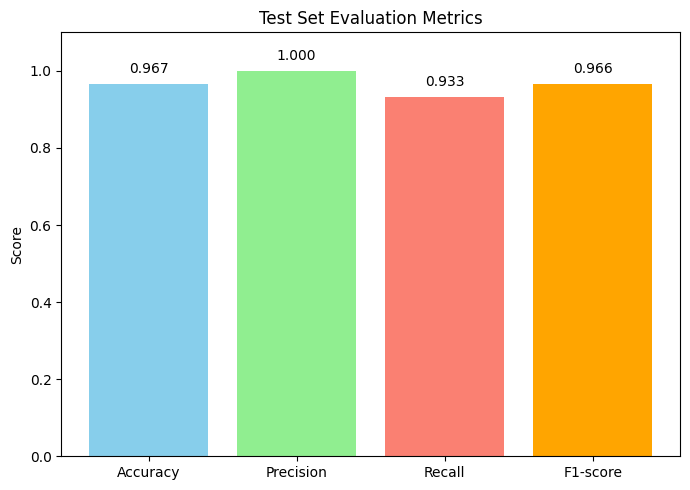

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Compute metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Prepare for plotting
metrics = [acc, prec, rec, f1]
metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

# Plot bar chart
fig, ax = plt.subplots(figsize=(7,5))
bars = ax.bar(metric_names, metrics, color=colors)
ax.set_ylim(0, 1.1)  # since all metrics are between 0 and 1
ax.set_ylabel("Score")
ax.set_title("Test Set Evaluation Metrics")

# Add text labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
